# "Markov Property of States"

> Reinforcement Learning (RL) to simulate a commodity price
- toc: true
- branch: master
- badges: false
- comments: true
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2
- image: images/MarkovPropertyOfStates.png
- categories: [Investment,   Markov_property,   Python]
- show_tags: true

## 1. Processes

In the context of finance we often have to deal with random processes, so-called *stochastic processes*. A process generates a sequence of random outcomes over time. We will only consider discrete time values and will index time by $t=0, 1,2,3,4, ...$. The evolution of the outcomes or data of a process might be considered as being generated by an underlying *system* whose internal *state* also changes with time. The outcomes is often called the *output* of the system. The output is a function of the input to the system as well as the internal state.

More formally, a stochastic process can be represented by a sequence of random variables of the evolving state

$$ \Large
\begin{aligned}
S_0,S_1, ...,S_{t-1},S_t,S_{t+1},S_{t+2},... \\
\end{aligned}
$$

where $S_t$ represents the state of the process in time $t$.

We have an interest in finding the probability of the next state $S_{t+1}$ given the present state $S_t$ as well as the past $S_0,S_1, ...,S_{t-1}$. This probability may be expressed as

$$ \Large
\mathbb P[S_{t+1}|S_t,S_{t-1},...,S_0]
$$

Now we introduce the concept of the *Markov Property of States*. This property allows the above equation to simplify to

$$ \Large
\mathbb P[S_{t+1}|S_t,S_{t-1},...,S_0]=\mathbb P[S_{t+1}|S_t]
$$

for all $t\ge0$. This means that the "*future is independent of the past given the present*". This property greatly simplifies the mathematics as well as the computational aspects.



## 2. Simulation for better insight

Next we will use an example from the financial domain to simulate the behavior of a process whose states possess this property. This will increase our level of insight. Let us simulate the price of an investment product, say a commodity. $X_t$ will indicate the commodity price at time $t$. For simplicity, at the end of each interval a prices may go up/down by one dollar. We will only have integer values for prices and will also allow zero and negative prices. This means $X_{t+1}$ will always either have the value $X_t+1$ or $X_t-1$. 

### 2.1 Process Simulation

The probability of an up-move will be

$$ \Large
\mathbb P[X_{t+1}=X_t+1] = \frac{1}{1 + e^{-\alpha(L-X_t)}}
$$

The probability of a down-move will be

$$ \Large
1 - \mathbb P[X_{t+1}=X_t+1] = 1 - \frac{1}{1 + e^{-\alpha(L-X_t)}}
$$

The expression on the RHS is known as a *logistic function of $L-X_t$*. The steepness of the logistic function is adjusted by $\alpha_1$. It represents how strongly the process tends to revert to its mean value. The parameter $\alpha$ is a positive or zero real number.

The parameter $L$ is an arbitrary reference level. We interpret this logistic function of $L-X_t$ as follows:

* if $X_t$ > $L$
  * $\mathbb P[X_{t+1}=X_t + 1] < 0.5$
  * down-pull is greater than up-pull
* if $X_t$ < $L$
  * $\mathbb P[X_{t+1}=X_t + 1] > 0.5$
  * up-pull is greater than down-pull

In summary, $L$ is the level to which the price mean-reverts, and $\alpha_1$ is the strength of the mean-reversion.



In [1]:
#hide
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive"
# base_dir = root_dir + '/Rao_CME241/RL-book/rl/gen-utils'
base_dir = root_dir + '/Rao_CME241/RL-book/rl'
# # base_dir = ""

Mounted at /content/gdrive


In [2]:
from dataclasses import dataclass
from typing import Optional, Mapping, Sequence, Tuple
from collections import Counter
import numpy as np
from numpy.random import binomial
import itertools as it
from operator import itemgetter

In [3]:
# hide
base_dir

'/content/gdrive/My Drive/Rao_CME241/RL-book/rl'

In [4]:
# hide
import sys
sys.path

['/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython']

In [5]:
# hide
# sys.path.insert(0, f"{base_dir}/gen_utils"); sys.path
sys.path.append(f"{base_dir}/gen_utils"); sys.path

['/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/gdrive/My Drive/Rao_CME241/RL-book/rl/gen_utils']

In [6]:
# hide
!ls -l "{sys.path[-1]}"

total 15
-rw------- 1 root root 3177 Sep 15 17:00 -common_funcs.ipynb
-rw------- 1 root root 1230 Sep 15 17:00 common_funcs.py
-rw------- 1 root root    0 Dec  5  2021 __init__.py
-rw------- 1 root root 3937 Sep 15 16:57 -plot_funcs.ipynb
-rw------- 1 root root 1226 Sep 16 11:29 plot_funcs.py
drwx------ 2 root root 4096 Dec 14  2021 __pycache__


In [7]:
# hide
import plot_funcs as mypf
import common_funcs as mycf

#### 2.1.1 Process implementation

We now start to implement this random process. `class Process1` has 3 attributes:

* `class State`
* `L: int` which is the leve to which the price mean-reverts
* `alpha: float` which is the strength of the mean-reversion

`class Process1` has 2 methods:

* `up_prob()` which finds $\mathbb P[X_{t+1} = X_t + 1]$
* `next_state()` which use `up_prob()` to sample from a Bernoulli distribution to create the next state $X_{t+1}$ from the current state $X_t$.

In [9]:
# hide
from typing import Callable
def get_logistic_func(alpha: float) -> Callable[[float], float]:
    return lambda x: 1./(1 + np.exp(-alpha*x))

In [10]:
@dataclass
class Process:
  @dataclass
  class State:
    price: int

  L: int #level to which price mean-reverts
  alpha1: float = 0.25 #strength of mean-reversion

  def up_prob(self, state: State) -> float:
    return mycf.get_logistic_func(self.alpha1)(self.L - state.price)

  def next_state(self, state: State) -> State:
    up_move: int = binomial(1, self.up_prob(state), 1)[0]
    return Process.State(price=state.price + up_move*2 - 1)    

Next we implement a simulator that generates one state value at a time:

In [11]:
def simulation(process, start_state):
    state = start_state
    while True:
        yield state
        state = process.next_state(state)

After this, we use the simulator to generate state/price traces. `num_traces` specify how many traces we want, each spanning `time_steps`. We also provide the `start_price`.

In [24]:
def process_price_traces(
    start_price: int,
    L: int,
    alpha: float,
    time_steps: int,
    num_traces: int
) -> np.ndarray:
    process = Process(L=L, alpha1=alpha1)
    start_state = Process.State(price=start_price)
    return np.vstack([
        np.fromiter((s.price for s in it.islice(
            simulation(process, start_state),
            time_steps + 1
        )), float) for _ in range(num_traces)])

Let's analyze this implementation so far. Here is an instance of a simulation generator:

In [25]:
#.
L = 7
alpha1 = 0.2
process = Process(L=L, alpha1=alpha1)
start_price = 10.0
start_state = Process.State(price=start_price)

simulation_gen = simulation(process, start_state)

Each time we call `next()` on `simulation_gen` we get a new state:

In [26]:
[next(simulation_gen) for i in range(10)]

[Process.State(price=10.0),
 Process.State(price=11.0),
 Process.State(price=10.0),
 Process.State(price=9.0),
 Process.State(price=8.0),
 Process.State(price=9.0),
 Process.State(price=10.0),
 Process.State(price=11.0),
 Process.State(price=10.0),
 Process.State(price=9.0)]

It is more elegant to do it with the `itertools.islice()` function:

In [27]:
list( it.islice(simulation_gen, 10) )

[Process.State(price=10.0),
 Process.State(price=11.0),
 Process.State(price=12.0),
 Process.State(price=11.0),
 Process.State(price=10.0),
 Process.State(price=9.0),
 Process.State(price=8.0),
 Process.State(price=7.0),
 Process.State(price=6.0),
 Process.State(price=5.0)]

In the next cell we ask for 5 traces to be generated with `num_traces = 5`, each spanning `time_steps + 1` time-steps.

In [28]:
num_traces = 5
time_steps = 10
# list( (s.price for s in it.islice(simulation_gen, time_steps + 1)) )
# np.fromiter((s.price for s in it.islice(simulation_gen, time_steps + 1)), float)
# [np.fromiter((s.price for s in it.islice(simulation_gen, time_steps + 1)), float) for _ in range(num_traces)]
np.vstack([np.fromiter((s.price for s in it.islice(simulation_gen, time_steps + 1)), float) for _ in range(num_traces)])

array([[6., 5., 4., 3., 4., 5., 4., 3., 4., 3., 4.],
       [3., 2., 3., 4., 3., 2., 3., 4., 5., 4., 5.],
       [6., 5., 4., 5., 6., 5., 6., 7., 6., 5., 4.],
       [5., 6., 5., 6., 7., 6., 5., 6., 5., 4., 3.],
       [2., 3., 4., 5., 6., 5., 4., 5., 6., 7., 8.]])

In [29]:
start_price: int = 100
L: int = 100
alpha: float = 0.28
time_steps: int = 200
num_traces: int = 3

In [30]:
process_traces: np.ndarray = process_price_traces(
    start_price=start_price,
    L=L,
    alpha=alpha,
    time_steps=time_steps,
    num_traces=num_traces
)
process_traces

array([[100.,  99., 100.,  99., 100.,  99.,  98.,  99.,  98.,  97.,  96.,
         97.,  98.,  97.,  96.,  97.,  98.,  99., 100.,  99.,  98.,  99.,
         98.,  99.,  98.,  99.,  98.,  99., 100.,  99., 100.,  99., 100.,
        101., 100.,  99., 100., 101., 102., 103., 102., 101., 102., 101.,
        102., 101., 102., 101., 100.,  99.,  98.,  97.,  96.,  95.,  96.,
         97.,  98.,  99.,  98.,  97.,  96.,  95.,  96.,  97.,  96.,  97.,
         96.,  95.,  96.,  95.,  94.,  95.,  96.,  97.,  98.,  99., 100.,
        101., 102., 101., 102., 101., 100.,  99.,  98.,  99., 100.,  99.,
         98.,  97.,  96.,  97.,  98.,  99.,  98.,  97.,  98.,  97.,  98.,
         97.,  96.,  97.,  98.,  97.,  98.,  97.,  96.,  95.,  96.,  97.,
         98.,  99., 100., 101., 102., 101., 100.,  99., 100., 101., 102.,
        101., 100.,  99., 100., 101., 102., 103., 104., 103., 102., 101.,
        102., 103., 104., 103., 102., 101., 100., 101., 100., 101., 100.,
         99., 100.,  99.,  98.,  99., 

#### 2.1.2 Process visualization

In [31]:
traces_len = len(process_traces[0])
[range(traces_len)] * 3

[range(0, 201), range(0, 201), range(0, 201)]

traces_len: 201


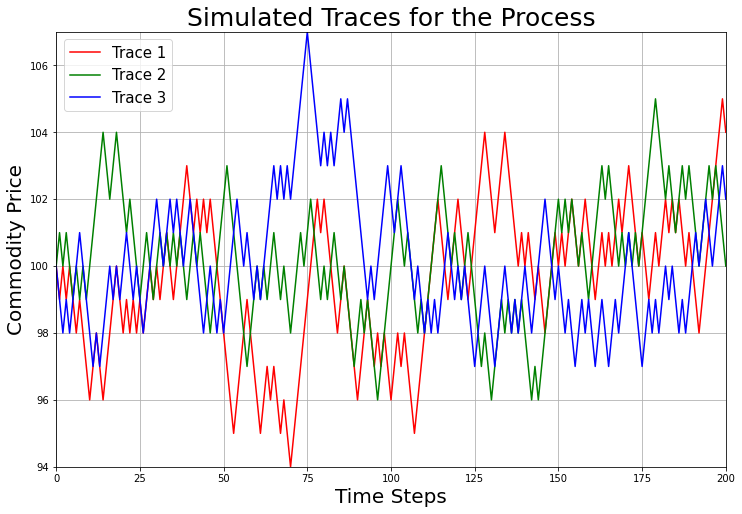

In [33]:
traces_len = len(process_traces[0]); print(f"traces_len: {traces_len}")
mypf.plot_list_of_curves(
    [range(traces_len)] * 3,
    process_traces,
    ["r", "g", "b"],
    [
        r"Trace 1",
        r"Trace 2",
        r"Trace 3"
    ],
    "Time Steps",
    "Commodity Price",
    "Simulated Traces for the Process"
)